In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
imgWidth, imgHeight, channels = 128, 128, 3
start_neurals = 16

train_path = '/home/thao/dataset/Skin lession/PH2 Dataset images'
test_path = '/home/thao/dataset/Skin lession/PH2 Dataset test'
train_ids = next(os.walk(train_path))[1]
test_ids = os.listdir(test_path)
print('Number of training samples: ', len(train_ids))
print('Number of testing samples: ', len(test_ids))

Number of training samples:  200
Number of testing samples:  121


In [6]:
# train images
X_train = np.zeros((len(train_ids), imgHeight, imgWidth, channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), imgHeight, imgWidth, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = id_ + '_Dermoscopic_Image/' + id_ + '.bmp'
    path = os.path.join(train_path, id_, path)
    img = imread(path)[:, :, :channels]
    img = resize(img, (imgHeight, imgWidth), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img

    path_mask = id_ + '_lesion/' + id_ + '_lesion.bmp'
    path_mask = os.path.join(train_path, id_, path_mask)
    mask = imread(path_mask)
    mask = np.expand_dims(resize(mask, (imgHeight, imgWidth), mode='constant',
                                      preserve_range=True), axis=-1)
    Y_train[n] = mask

  1%|          | 2/200 [00:00<00:19, 10.21it/s]

Resizing training images and masks


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


In [7]:
# test images
X_test = np.zeros((len(test_ids), imgHeight, imgWidth, channels), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(test_path, id_)
    img = imread(path)[:, :, :channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (imgHeight, imgWidth), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

  2%|▏         | 3/121 [00:00<00:04, 29.49it/s]

Resizing test images


100%|██████████| 121/121 [00:06<00:00, 18.81it/s]

Done!


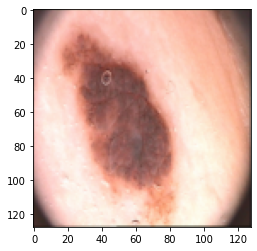

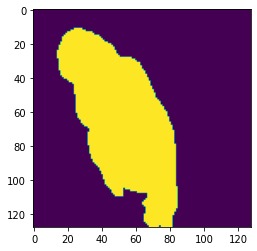

In [8]:
image_x = random.randint(0, len(train_ids))
plt.imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [9]:
#_______________________________________________ Build the model _______________________________________________________
# inputs:
inputs = tf.keras.layers.Input((imgWidth, imgHeight, channels))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
# conv1:
conv1 = tf.keras.layers.Conv2D(start_neurals, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(start_neurals, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPool2D((2,2))(conv1)
# conv2:
conv2 = tf.keras.layers.Conv2D(start_neurals*2, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(start_neurals*2, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPool2D((2,2))(conv2)
# conv3:
conv3 = tf.keras.layers.Conv2D(start_neurals*4, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(start_neurals*4, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPool2D((2,2))(conv3)
# conv4:
conv4 = tf.keras.layers.Conv2D(start_neurals*8, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(start_neurals*8, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(conv4)
pool4 = tf.keras.layers.MaxPool2D((2,2))(conv4)
# middle
middle = tf.keras.layers.Conv2D(start_neurals*16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
middle = tf.keras.layers.Dropout(0.3)(middle)
middle = tf.keras.layers.Conv2D(start_neurals*16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(middle)
# deconv4:
deconv4 = tf.keras.layers.Conv2DTranspose(start_neurals*8, (2,2), strides=(2,2), padding='same')(middle)
unconv4 = tf.keras.layers.concatenate([deconv4,conv4])
unconv4 = tf.keras.layers.Conv2D(start_neurals*8, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv4)
unconv4 = tf.keras.layers.Dropout(0.2)(unconv4)
unconv4 = tf.keras.layers.Conv2D(start_neurals*8, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv4)
# deconv3:
deconv3 = tf.keras.layers.Conv2DTranspose(start_neurals*4, (2,2), strides=(2,2), padding='same')(unconv4)
unconv3 = tf.keras.layers.concatenate([deconv3,conv3])
unconv3 = tf.keras.layers.Conv2D(start_neurals*4, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv3)
unconv3 = tf.keras.layers.Dropout(0.2)(unconv3)
unconv3 = tf.keras.layers.Conv2D(start_neurals*4, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv3)
# deconv2:
deconv2 = tf.keras.layers.Conv2DTranspose(start_neurals*2, (2,2), strides=(2,2), padding='same')(unconv3)
unconv2 = tf.keras.layers.concatenate([deconv2,conv2])
unconv2 = tf.keras.layers.Conv2D(start_neurals*2, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv2)
unconv2 = tf.keras.layers.Dropout(0.1)(unconv2)
unconv2 = tf.keras.layers.Conv2D(start_neurals*2, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv2)
# deconv1:
deconv1 = tf.keras.layers.Conv2DTranspose(start_neurals, (2,2), strides=(2,2), padding='same')(unconv2)
unconv1 = tf.keras.layers.concatenate([deconv1,conv1])
unconv1 = tf.keras.layers.Conv2D(start_neurals, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv1)
unconv1 = tf.keras.layers.Dropout(0.1)(unconv1)
unconv1 = tf.keras.layers.Conv2D(start_neurals, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(unconv1)
# outputs:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid', padding='same')(unconv1)
# build model:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
#_______________________________________________ Model checkpoint _______________________________________________________
checkpointer = tf.keras.callbacks.ModelCheckpoint('/home/thao/PycharmProjects/skin_lesion.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs_skinlesion')
]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
12/12 [==============================] - 17s 1s/step - loss: 0.6631 - accuracy: 0.5981 - val_loss: 0.5536 - val_accuracy: 0.7171
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 0.5883 - accuracy: 0.6523 - val_loss: 0.5095 - val_accuracy: 0.7171
Epoch 3/100
12/12 [==============================] - 18s 2s/step - loss: 0.5310 - accuracy: 0.6774 - val_loss: 0.4355 - val_accuracy: 0.7922
Epoch 4/100
12/12 [==============================] - 20s 2s/step - loss: 0.4576 - accuracy: 0.8079 - val_loss: 0.3528 - val_accuracy: 0.8881
Epoch 5/100
12/12 [==============================] - 18s 2s/step - loss: 0.4013 - accuracy: 0.8526 - val_loss: 0.3082 - val_accuracy: 0.8943
Epoch 6/100
12/12 [==============================] - 17s 1s/step - loss: 0.3639 - accuracy: 0.8645 - val_loss: 0.4112 - val_accuracy: 0.8148
Epoch 7/100
12/12 [==============================] - 17s 1s/step - loss: 0.3850 - accuracy: 0.8479 - val_loss: 0.2996 - val_accuracy: 0.8883
Epoch 8/100
1

4/4 [==============================] - 2s 458ms/step


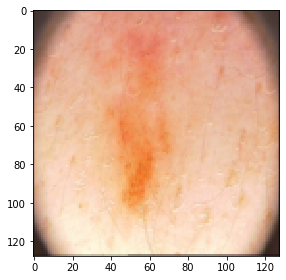

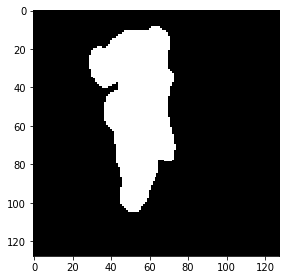

/home/thao/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


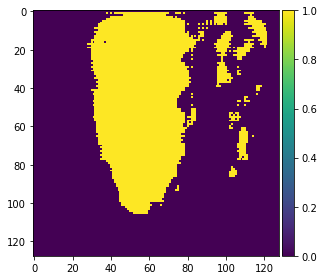

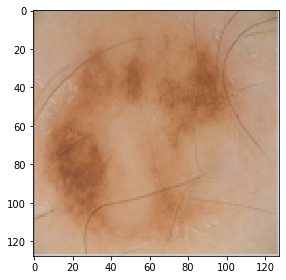

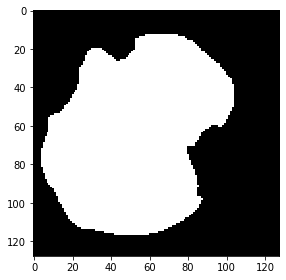

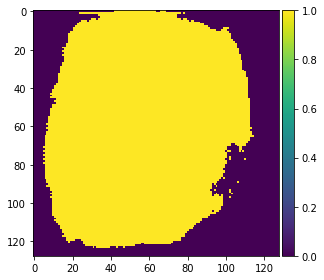

In [11]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0] * 0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
